In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
!pip install onnx

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 15.7/15.7 MB 68.5 MB/s eta 0:00:00


In [3]:
import torch
from torchvision import datasets, transforms, models
from torch.utils.data import DataLoader, random_split, Subset
from torch import nn, onnx
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.tensorboard import SummaryWriter

from sklearn.metrics import confusion_matrix, precision_score, recall_score
from sklearn.model_selection import train_test_split
import seaborn as sns
import matplotlib.pyplot as plt
# from matplotlib.colors import LinearSegmentedColormap

import numpy as np


In [4]:
### data preprocess

# resize image size and set it to tensor for dataloader
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
])

# use imagefolder to get all image samples with labels in each class folder
dataset = datasets.ImageFolder(root='/content/drive/MyDrive/comp8420/Subset For Assignment SFEW', transform=transform)

# Split datasets
train_indices = []
valid_indices = []
test_indices = []
for class_index in range(len(dataset.classes)):
  class_indices = [i for i, (img, label) in enumerate(dataset.samples) if label == class_index]
  train_class_indices, test_class_indices = train_test_split(class_indices, test_size=0.2, random_state=42)
  valid_class_indices, test_class_indices = train_test_split(test_class_indices, test_size=0.5, random_state=42)

  train_indices.extend(train_class_indices)
  valid_indices.extend(valid_class_indices)
  test_indices.extend(test_class_indices)

# Create subset dataloaders
train_dataset = Subset(dataset, train_indices)
valid_dataset = Subset(dataset, valid_indices)
test_dataset = Subset(dataset, test_indices)
train_dataloader = DataLoader(train_dataset, batch_size=32, shuffle=True)
valid_dataloader = DataLoader(valid_dataset, batch_size=32, shuffle=False)
test_dataloader = DataLoader(test_dataset, batch_size=32, shuffle=False)

In [ ]:
# get the class index to differ each face emotion
class_index = dataset.class_to_idx
class_index

{'Angry': 0,
 'Disgust': 1,
 'Fear': 2,
 'Happy': 3,
 'Neutral': 4,
 'Sad': 5,
 'Surprise': 6}

In [5]:
class SpatialAttention(nn.Module):
  def __init__(self, kernel_size=7):
    super(SpatialAttention, self).__init__()
    assert kernel_size in (3, 7), 'kernel size must be 3 or 7'
    padding = 3 if kernel_size == 7 else 1

    self.conv1 = nn.Conv2d(2, 1, kernel_size, padding=padding, bias=False)
    self.sigmoid = nn.Sigmoid()

  def forward(self, x):
    # Average along channel axis
    avg_out = torch.mean(x, dim=1, keepdim=True)
    # Max along channel axis
    max_out, _ = torch.max(x, dim=1, keepdim=True)
    # Stack channel-wise
    x = torch.cat([avg_out, max_out], dim=1)
    x = self.conv1(x)
    return self.sigmoid(x)


In [6]:
class ResNetSA(nn.Module):
  def __init__(self, num_classes=7):
    super(ResNetSA, self).__init__()
    self.resnet = models.resnet18(pretrained=True)
    # self.resnet = models.resnet50(pretrained=True)
    self.resnet.fc = nn.Linear(self.resnet.fc.in_features, num_classes)
    self.sa = SpatialAttention()

  def forward(self, x):
    x = self.resnet.conv1(x)
    x = self.resnet.bn1(x)
    x = self.resnet.relu(x)
    x = self.resnet.maxpool(x)

    x = self.sa(x) * x

    x = self.resnet.layer1(x)
    # x = self.sa(x) * x  # Spatial Attention

    x = self.resnet.layer2(x)
    # x = self.sa(x) * x

    x = self.resnet.layer3(x)
    # x = self.sa(x) * x

    x = self.resnet.layer4(x)
    # x = self.sa(x) * x

    x = self.resnet.avgpool(x)
    x = torch.flatten(x, 1)
    x = self.resnet.fc(x)

    return x


/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 139MB/s]


Epoch [1/50], Loss: 2.1341
Epoch [2/50], Loss: 1.4366
Epoch [3/50], Loss: 0.9231
Epoch [4/50], Loss: 0.5189
Epoch [5/50], Loss: 0.3509
Epoch [6/50], Loss: 0.3255
Epoch [7/50], Loss: 0.2618
Epoch [8/50], Loss: 0.1952
Epoch [9/50], Loss: 0.2540
Epoch [10/50], Loss: 0.2034
Epoch [11/50], Loss: 0.2170
Epoch [12/50], Loss: 0.1383
Epoch [13/50], Loss: 0.0644
Epoch [14/50], Loss: 0.0616
Epoch [15/50], Loss: 0.0612
Epoch [16/50], Loss: 0.0391
Epoch [17/50], Loss: 0.0247
Epoch [18/50], Loss: 0.0194
Epoch [19/50], Loss: 0.0107
Epoch [20/50], Loss: 0.0078
Epoch [21/50], Loss: 0.0116
Epoch [22/50], Loss: 0.0102
Epoch [23/50], Loss: 0.0076
Epoch [24/50], Loss: 0.0073
Epoch [25/50], Loss: 0.0084
Epoch [26/50], Loss: 0.0081
Epoch [27/50], Loss: 0.0069
Epoch [28/50], Loss: 0.0064
Epoch [29/50], Loss: 0.0058
Epoch [30/50], Loss: 0.0078
Epoch [31/50], Loss: 0.0080
Epoch [32/50], Loss: 0.0063
Epoch [33/50], Loss: 0.0083
Epoch [34/50], Loss: 0.0069
Epoch [35/50], Loss: 0.0072
Epoch [36/50], Loss: 0.0066
E

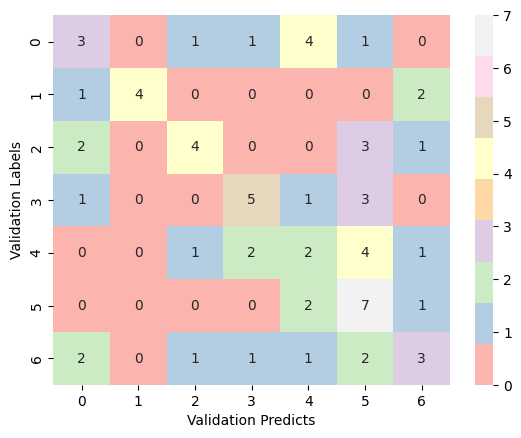

Test Accuracy: 37.68%


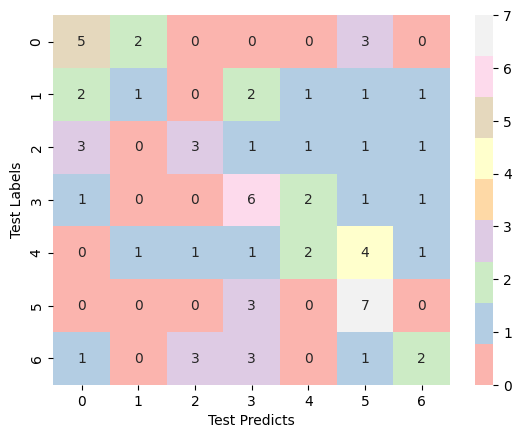

In [7]:
### start to run model

# load emotionnet model and set loss and optimizer
num_epochs = 50
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = ResNetSA().to(device)
# model = models.resnet18(pretrained=True).to(device)
# model = models.resnet50(pretrained=True).to(device)

criterion = nn.CrossEntropyLoss()
# optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)
optimizer = optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-5)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.9)

# use tensorboard to record training process
writer = SummaryWriter('/content/drive/MyDrive/comp8420/runs_resnet18input')
## train
for epoch in range(num_epochs):
  model.train()
  running_loss = 0.0
  correct = 0
  total = 0
  # batch size
  for images, labels in train_dataloader:
    images, labels = images.to(device), labels.to(device)
    optimizer.zero_grad()
    # predicts
    outputs = model(images)
    loss = criterion(outputs, labels)
    loss.backward()
    optimizer.step()
    running_loss += loss.item()
    _, predicts = torch.max(outputs, 1)
    total += labels.size(0)
    correct += (predicts == labels).sum().item()
  # update learning rate
  scheduler.step()
  print('Epoch [{}/{}], Loss: {:.4f}'.format(epoch+1, num_epochs, running_loss/len(train_dataloader)))
  # write outputs in tensorboard
  writer.add_scalar('training loss:', running_loss / len(train_dataloader), epoch)
  writer.add_scalar('training accuracy:', 100 * correct / total, epoch)
  # weight analysis
  for name, param in model.named_parameters():
    writer.add_histogram(name, param.clone().cpu().data.numpy(), epoch)

  ## validation
  model.eval()
  correct = 0
  total = 0
  val_predicts = []
  val_labels = []
  with torch.no_grad():
    for images, labels in valid_dataloader:
      images, labels = images.to(device), labels.to(device)
      outputs = model(images)
      _, predicts = torch.max(outputs, 1)
      total += labels.size(0)
      correct += (predicts == labels).sum().item()

      val_predicts.extend(predicts.cpu().numpy())
      val_labels.extend(labels.cpu().numpy())

  # write outputs in tensorboard
  writer.add_scalar('validation loss:', running_loss / len(train_dataloader), epoch)
  writer.add_scalar('validation accuracy:', 100 * correct / total, epoch)

# plot the outputs
sns.heatmap(confusion_matrix(val_labels,val_predicts), annot=True, fmt='d', cmap='Pastel1')
plt.xlabel('Validation Predicts')
plt.ylabel('Validation Labels')
plt.show()

writer.close()
# save model
# torch.save(model.state_dict(), '/content/drive/MyDrive/comp8420/emotionNet_model.pth')
dummy_input = torch.randn(1, 3, 224, 224, device=device)
onnx_path = "/content/drive/MyDrive/comp8420/emotionNet_resnet18input.onnx"  # The file path to save the ONNX model
onnx.export(model, dummy_input, onnx_path)

## test
correct = 0
total = 0
test_predicts = []
test_labels = []
with torch.no_grad():
    for images, labels in test_dataloader:
      images, labels = images.to(device), labels.to(device)
      outputs = model(images)
      _, predicts = torch.max(outputs, 1)
      total += labels.size(0)
      correct += (predicts == labels).sum().item()
      test_predicts.extend(predicts.cpu().numpy())
      test_labels.extend(labels.cpu().numpy())
print('Test Accuracy: {:.2f}%'.format(100 * correct / total))
# plot the outputs
sns.heatmap(confusion_matrix(test_labels,test_predicts), annot=True, fmt='d', cmap='Pastel1',vmin=0, vmax=7)
plt.xlabel('Test Predicts')
plt.ylabel('Test Labels')
plt.show()

In [ ]:
# 计算混淆矩阵
cm = confusion_matrix(test_labels, test_predicts)

# 计算precision和recall
precision = precision_score(test_labels, test_predicts, average=None)
recall = recall_score(test_labels, test_predicts, average=None)

# 计算特异性
specificity = np.zeros_like(precision)
for i in range(len(specificity)):
    true_negative = np.sum(cm) - np.sum(cm[i, :]) - np.sum(cm[:, i]) + cm[i, i]
    false_positive = np.sum(cm[:, i]) - cm[i, i]
    specificity[i] = true_negative / (true_negative + false_positive)

# 打印每个类别的结果
for i in range(len(precision)):
    print("Class {}: Precision: {:.2f}, Recall: {:.2f}, Specificity: {:.2f}".format(i, precision[i], recall[i], specificity[i]))


Class 0: Precision: 0.50, Recall: 0.20, Specificity: 0.97
Class 1: Precision: 0.20, Recall: 0.12, Specificity: 0.93
Class 2: Precision: 0.67, Recall: 0.40, Specificity: 0.97
Class 3: Precision: 0.36, Recall: 0.73, Specificity: 0.76
Class 4: Precision: 0.30, Recall: 0.30, Specificity: 0.88
Class 5: Precision: 0.55, Recall: 0.60, Specificity: 0.92
Class 6: Precision: 0.36, Recall: 0.40, Specificity: 0.88


In [9]:
!pip install grad-cam


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 22.3 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Created wheel for grad-cam: filename=grad_cam-1.4.8-py3-none-any.whl size=38244 sha256=0ef9c0c346000ebc60836e71b71cfb51679b29a1f82d51ffa6139149bea333c7
  Stored in directory: /root/.cache/pip/wheels/f8/04/36/94ff3c8a4215826a21946b34c01180817e606989fdf53f7cd6
Successfully built grad-cam


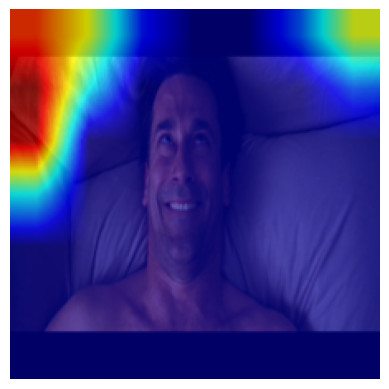

In [10]:
from pytorch_grad_cam import GradCAM
from pytorch_grad_cam.utils.model_targets import ClassifierOutputTarget
from pytorch_grad_cam.utils.image import show_cam_on_image
from torchvision.transforms import transforms
from PIL import Image
import matplotlib.pyplot as plt

# 加载预训练的ResNet18模型
# model = resnet18(pretrained=True).to(device)
model.eval()

# 指定目标层
target_layers = [model.resnet.layer4[-1]]

# 创建一个输入张量图像
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
])
image = Image.open("/content/drive/MyDrive/comp8420/Subset For Assignment SFEW/Happy/Bridesmaids_000059880_00000039.png")
input_tensor = transform(image).unsqueeze(0).to(device)

# 构造CAM对象
cam = GradCAM(model=model, target_layers=target_layers, use_cuda=device=='cuda')

# 指定我们想要生成类激活图的目标。
# 这里我们使用ClassifierOutputTarget，但你可以定义你自己的自定义目标。
targets = [ClassifierOutputTarget(0)]  # 假设你想要可视化类别0的激活图

# 生成灰度激活图
grayscale_cam = cam(input_tensor=input_tensor, targets=targets)[0, :]

# 将激活图显示在原始图像上
visualization = show_cam_on_image(input_tensor.cpu().numpy()[0].transpose(1, 2, 0), grayscale_cam, use_rgb=True)

# 显示可视化结果
plt.imshow(visualization)
plt.axis('off')
plt.show()


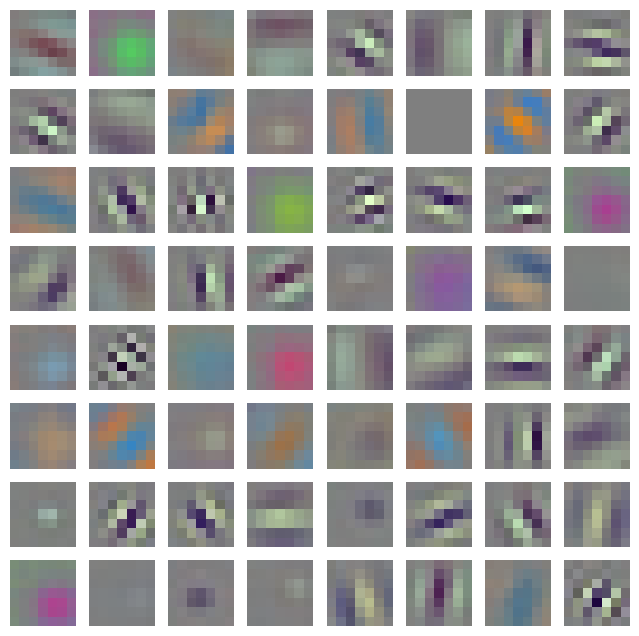

In [ ]:
# 提取卷积核权重
kernels = model.resnet.conv1.weight.data.cpu().numpy()
kernels = kernels.transpose(0, 2, 3, 1)  # 调整为 (out_channels, kernel_size, kernel_size, in_channels)
kernels = (kernels - kernels.min()) / (kernels.max() - kernels.min())  # 归一化到 [0, 1]

# 创建一个画布来显示所有卷积核
fig, axs = plt.subplots(8, 8, figsize=(8, 8))
for i in range(64):  # 假设你有64个滤波器
    row = i // 8
    col = i % 8
    axs[row, col].imshow(kernels[i, :, :, :], cmap='viridis')
    axs[row, col].axis('off')
plt.show()


In [ ]:
from sklearn.metrics import classification_report

report = classification_report(val_labels, val_predicts)
print(report)

report = classification_report(test_labels, test_predicts)
print(report)

              precision    recall  f1-score   support

           0       0.44      0.40      0.42        10
           1       0.67      0.57      0.62         7
           2       0.36      0.40      0.38        10
           3       0.67      0.40      0.50        10
           4       0.30      0.30      0.30        10
           5       0.47      0.70      0.56        10
           6       0.50      0.50      0.50        10

    accuracy                           0.46        67
   macro avg       0.49      0.47      0.47        67
weighted avg       0.48      0.46      0.46        67

              precision    recall  f1-score   support

           0       0.50      0.60      0.55        10
           1       0.14      0.12      0.13         8
           2       0.38      0.50      0.43        10
           3       0.30      0.27      0.29        11
           4       0.50      0.20      0.29        10
           5       0.58      0.70      0.64        10
           6       0.27 

In [ ]:
%load_ext tensorboard


The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


In [ ]:
%tensorboard --logdir=/content/drive/MyDrive/comp8420/runs --port=6007


<IPython.core.display.Javascript object>